# Deep Learning Lecture 7

From Last week, we will still be using Nietzsche for our source text and will continue on with RNNs

In [1]:
PATH='/home/paperspace/Desktop/'

In [2]:
text = open(f'{PATH}nietzsche.txt').read()

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../repos/fastai/')
import torch

from fastai.io import *
from fastai.conv_learner import *


from fastai.column_data import *

### Continuing with the three character Model

In [8]:
chars = sorted(list(set(text)))
vocab_size = len(chars)+1
chars.insert(0, "\0")

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
idx = [char_indices[c] for c in text]

#### Creating lists of characters offset by n chars

In [9]:
cs=3
c1_dat = [idx[i]   for i in range(0, len(idx)-1-cs, cs)]
c2_dat = [idx[i+1] for i in range(0, len(idx)-1-cs, cs)]
c3_dat = [idx[i+2] for i in range(0, len(idx)-1-cs, cs)]
c4_dat = [idx[i+3] for i in range(0, len(idx)-1-cs, cs)]

#### Creating Inputs and outputs, our y is the 4th character that we are trying to predict

In [10]:
x1 = np.stack(c1_dat[:-2])
x2 = np.stack(c2_dat[:-2])
x3 = np.stack(c3_dat[:-2])
y = np.stack(c4_dat[:-2])

#### A quick peak to show what the inputs look like

In [11]:
x1[:4], x2[:4], x3[:4]

(array([40, 30, 29,  1]), array([42, 25,  1, 43]), array([29, 27,  1, 45]))

Pick a size for our hidden state, as well as the number of latent factors to create the size of the embedding matrix

In [13]:
n_hidden = 256
n_fac = 42

#### Our Initial Model (representing the RNN powerpoint diagram)

<img src='https://snag.gy/c0tT23.jpg' style='width:600px'/> 

In [14]:
class Char3Model(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)

        # The 'green arrow' from our diagram - the layer operation from input to hidden
        self.l_in = nn.Linear(n_fac, n_hidden)

        # The 'orange arrow' from our diagram - the layer operation from hidden to hidden
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        
        # The 'blue arrow' from our diagram - the layer operation from hidden to output
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, c1, c2, c3):
        in1 = F.relu(self.l_in(self.e(c1)))
        in2 = F.relu(self.l_in(self.e(c2)))
        in3 = F.relu(self.l_in(self.e(c3)))
        
        h = V(torch.zeros(in1.size()).cuda())
        h = F.tanh(self.l_hidden(h+in1))
        h = F.tanh(self.l_hidden(h+in2))
        h = F.tanh(self.l_hidden(h+in3))
        
        return F.log_softmax(self.l_out(h))

#### Then we added a loop to increase number of 8 layers

In [16]:
class CharLoopModel(nn.Module):
    # This is an RNN!
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.l_in = nn.Linear(n_fac, n_hidden)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        h = V(torch.zeros(bs, n_hidden).cuda())
        
        # ================= new loop code =====================
        for c in cs:
            inp = F.relu(self.l_in(self.e(c)))
            h = F.tanh(self.l_hidden(h+inp))
        # ================= new loop code =====================
        
        
        return F.log_softmax(self.l_out(h), dim=-1)

#### Use the inbuilt RNN class in pytorch

In [ ]:
class CharRnn(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        h = V(torch.zeros(1, bs, n_hidden))
        inp = self.e(torch.stack(cs))
        outp,h = self.rnn(inp, h)
        
        return F.log_softmax(self.l_out(outp[-1]), dim=-1)

### To this point we have been only predicting the next character. We have been inching over piece by piece

You will notice that everytime we call "`forward`" we are resetting our activation values back to zero. We are losing some information. Is there any way to save this information and move it forward?

`init_hidden` - sets all our activations to zero, now we need to store this|

In [ ]:
class CharSeqStatefulRnn(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        self.vocab_size = vocab_size
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h.size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(cs), self.h)

        # note  this lin
        self.h = repackage_var(h) 
        
        
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs): self.h = V(torch.zeros(1, bs, n_hidden))

### If we had a 1 million character long text, we would have a 1 million layer fully connected network. It's a lot of computation

How much does character 1 impact the output, how much does the 2nd character impact the final output. Remember the diagram below:

<img src='https://snag.gy/h68R9i.jpg' style='width:600px' />

#### Solution: Forget some of your history
We want to remember the current state, but not all the history on how we got there.
- ` self.h = repackage_var(h) ` - will get the tensor (activations) out of the variable, and make a new variable out of that. (but no history of operations).
- It will backpropogate through 8 layers, but throw away the history of operations, this is also called **Backprop through time = bptt**
- Another reason not to backprop all the way back is because of exploding gradients; more layers, more chances the gradients will go through the roof.

In [18]:
??repackage_var

Object `repackage_var` not found.


#### How are we going to put hte data into this class?

We could traverse the text piece by piece, but ideally we would want to use a mini-batch (many at a time). How can we look at several sections at a time and predict the next section? Ideally these sections should be far enough away from each other to prevent any interactions.

**Luckily torch text makes mini-batches**

We split this into 64 equal sized chunks. If a total text was 64M characters, we would have 64 x 1M chunks. Then we would subdivide them into bptt. So our first minibatch would be : 64 x bptt chunk. 

If you are concerned with speed, you may want to adjust bptt.

## Using Torch Text

To prep for using torch text we will copy it both. Then we put 80% of the text in trn and 20% of the text in val.

In [1]:
import sys
sys.path.append('../repos/fastai/')
import torch
from torchtext import vocab, data

from fastai.nlp import *
from fastai.lm_rnn import *

PATH='data/nietzsche/'


#### Breaking up our text into 80% train and 20% test

In [15]:
with open('data/nietzsche/nietzsche.txt') as f:
    text = f.readlines()
    text_line_length = len(text)
    trn_index = int(text_line_length*.8)
    trn = text[:trn_index]
    tst = text[trn_index:]
    with open('data/nietzsche/trn/trn.txt','w') as f2:
        f2.writelines(trn)
    with open('data/nietzsche/val/val.txt','w') as f3:
        f3.writelines(tst)        

In [16]:
TRN_PATH = 'trn/'
VAL_PATH = 'val/'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

%ls {PATH}

nietzsche.txt  trn/  val/


### Torch Text

- `Field` - a description of how to go about preprocessing the text. lowercase it, and tokenize it.
- `tokenize` - we use list, which will take an input string and turn into an array of characters
- `bs` = batch size
- `bptt` = same number of characters to go back in time
- `n_fac` = size of embedding
- `n_hidden` = size of the state that is created between the orange arrows
- `FILES` - simple dictionary
- `LanguageModelData` - will take in all our text files that we pass it

We can't shuffle the data, because we need to be continous. But to add some randomness, we can randomize the length of `bptt` a little bit to vary the problem. It will be constant per mini-batch, but will vary per batch. 

In [17]:
TEXT = data.Field(lower=True, tokenize=list)
bs=64; bptt=8; n_fac=42; n_hidden=256

FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=3)

len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(942, 55, 1, 482972)

### note that `TEXT` has been transformed after running

In [22]:
TEXT.vocab.stoi.items()

dict_items([('<unk>', 0), ('<pad>', 1), (' ', 2), ('e', 3), ('t', 4), ('i', 5), ('a', 6), ('o', 7), ('n', 8), ('s', 9), ('r', 10), ('h', 11), ('l', 12), ('d', 13), ('c', 14), ('u', 15), ('f', 16), ('m', 17), ('p', 18), ('g', 19), (',', 20), ('y', 21), ('w', 22), ('b', 23), ('v', 24), ('-', 25), ('.', 26), ('"', 27), ('k', 28), ('x', 29), (';', 30), (':', 31), ('q', 32), ('j', 33), ('!', 34), ('?', 35), ('(', 36), (')', 37), ("'", 38), ('z', 39), ('1', 40), ('2', 41), ('=', 42), ('_', 43), ('3', 44), ('[', 45), (']', 46), ('4', 47), ('5', 48), ('6', 49), ('8', 50), ('7', 51), ('9', 52), ('0', 53), ('ä', 54), ('æ', 0), ('ë', 0), ('é', 0), ('<eos>', 0)])

### We will use our updated model

The very last mini-batch will be shorter, but most datasets are usually not evenly divisible. As a result, we add an check. And then will reset at the start of the next epoch.

```if self.h.size(1) != bs: self.init_hidden(bs)```


#### One last note, softmax isn't happy to accept rank3 tensor. Expects a rank 2 or 4 tensor.

- bptt x bs = predictions
- bptt x bs = actuals

Ideally our loss function would compare the two matrices item by item. But instead, we will unravel and compare both lists.

```F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)```

`dim=-1`- which axis we want to do the softmax over. In this case we want to do it over the last axis (they have the probability over the alphabet).

Torch Text already knows to do this with the target, so the library will take care of it


#### Get rid of the history 
```self.h = repackage_var(h)```


In [23]:
class CharSeqStatefulRnn(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        self.vocab_size = vocab_size
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h.size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(cs), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs): self.h = V(torch.zeros(1, bs, n_hidden))

In [24]:
m = CharSeqStatefulRnn(md.nt, n_fac, 512).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [25]:
fit(m, md, 4, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

[ 0.       1.88276  1.85243]                                 
[ 1.       1.70766  1.70842]                                 
[ 2.       1.62306  1.6326 ]                                 
[ 3.       1.57726  1.59751]                                 



In [26]:
set_lrs(opt, 1e-4)

fit(m, md, 4, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

[ 0.       1.49942  1.56189]                                 
[ 1.       1.49568  1.55378]                                 
[ 2.       1.49876  1.55345]                                 
[ 3.       1.49062  1.54595]                                 



#### Let's modify the code once again to gain some understanding

```python
def RNNCell(input, hidden, w_ih, w_hh, b_ih, b_hh):
    return F.tanh(F.linear(input, w_ih, b_ih) + F.linear(hidden, w_hh, b_hh))
```

We will replace to simply show that we can append. Often times we will do this to incorporate some regularization approaches that are currently not supported. 

```python
 for c in cs: 
            o = self.rnn(self.e(c), o)
            outp.append(o)
```

Gradient explosions are pretty common, and the learning rate is kept fairly low.

In [ ]:
 class CharSeqStatefulRnn2(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        super().__init__()
        self.vocab_size = vocab_size
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNNCell(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h.size(1) != bs: self.init_hidden(bs)
        outp = []
        o = self.h
        for c in cs: 
            o = self.rnn(self.e(c), o)
            outp.append(o)
        outp = self.l_out(torch.stack(outp))
        self.h = repackage_var(o)
        return F.log_softmax(outp, dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs): self.h = V(torch.zeros(1, bs, n_hidden))

## Gated Recurrent Unit
#### How can we compensate for the exploding gradient? A GRU unit

<img src='https://snag.gy/8vINsZ.jpg' style='width:400px' />
`z-gate` - do we use the hidden state as-is, or the updated hidden state.  
<img src='https://snag.gy/rZsAGt.jpg' style='width:200px' />
`r` We can see from the math notation that the `r` is somewhat of a mini-neural net. This makes a new hidden state.
<img src='https://snag.gy/gdj6OQ.jpg' style='width:400px' />


#### from the pytorch docs:
```python

def GRUCell(input, hidden, w_ih, w_hh, b_ih, b_hh):
    gi = F.linear(input, w_ih, b_ih)
    gh = F.linear(hidden, w_hh, b_hh)
    i_r, i_i, i_n = gi.chunk(3, 1)
    h_r, h_i, h_n = gh.chunk(3, 1)

    resetgate = F.sigmoid(i_r + h_r)
    inputgate = F.sigmoid(i_i + h_i)
    newgate = F.tanh(i_n + resetgate * h_n)
    return newgate + inputgate * (hidden - newgate)
```

In [28]:
class CharSeqStatefulGRU(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        super().__init__()
        self.vocab_size = vocab_size
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.GRU(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h.size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(cs), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs): self.h = V(torch.zeros(1, bs, n_hidden))

In [29]:
m = CharSeqStatefulGRU(md.nt, n_fac, 512).cuda()

opt = optim.Adam(m.parameters(), 1e-3)

In [30]:
fit(m, md, 6, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

[ 0.       1.75981  1.74155]                                 
[ 1.       1.58811  1.5903 ]                                 
[ 2.       1.4957   1.53097]                                 
[ 3.       1.44033  1.49259]                                 
[ 4.       1.41158  1.47094]                                 
[ 5.       1.38023  1.46393]                                 



In [31]:
set_lrs(opt, 1e-4)

In [32]:
fit(m, md, 3, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       1.29061  1.43124]                                 
[ 1.       1.28919  1.42574]                                 
[ 2.       1.2896   1.42517]                                 



http://colah.github.io/posts/2015-08-Understanding-LSTMs/

http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/

## LSTM

In [33]:
from fastai import sgdr

n_hidden=512

### Changes

- double size the hidden layer
- add drop out

In [35]:
class CharSeqStatefulLSTM(nn.Module):
    def __init__(self, vocab_size, n_fac, bs, nl):
        super().__init__()
        self.vocab_size,self.nl = vocab_size,nl
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.LSTM(n_fac, n_hidden, nl, dropout=0.5)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h[0].size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(cs), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.h = (V(torch.zeros(self.nl, bs, n_hidden)),
                  V(torch.zeros(self.nl, bs, n_hidden)))

### Let's take a look at callbacks

Instead of `opt = optim.Adam(m.parameters(), 1e-3)` we will use a `fastai` component: `LayerOptimizer`

In [36]:
m = CharSeqStatefulLSTM(md.nt, n_fac, 512, 2).cuda()
lo = LayerOptimizer(optim.Adam, m, 1e-2, 1e-5)

In [37]:
os.makedirs(f'{PATH}models', exist_ok=True)

#### A regular fit

In [38]:
fit(m, md, 2, lo.opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.80825  1.73351]                                 
[ 1.       1.70815  1.64764]                                 



#### Lets add some callbacks

Callbacks are like hooks you can pass functions for start of training, end of training, etc.
- `cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2, on_cycle_end=on_end)]`
- `len(md.trn_dl)` - how often to reset
- `on_cycle_end=on_end` - we can save the model
- This adds a cosine annealing callback

In [41]:
on_end = lambda sched, cycle: save_model(m, f'{PATH}models/cyc_{cycle}')
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2, on_cycle_end=on_end)]
fit(m, md, 2**4-1, lo.opt, F.nll_loss, callbacks=cb)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       1.54076  1.49328]                                 
[ 1.       1.59538  1.52947]                                 
[ 2.       1.47049  1.43788]                                 
[ 3.       1.61908  1.55599]                                 
[ 4.       1.54383  1.49159]                                 
[ 5.       1.45576  1.42396]                                 
[ 6.       1.39128  1.39265]                                 
[ 7.       1.59309  1.52709]                                 
[ 8.       1.56137  1.51185]                                 
[ 9.       1.524    1.48156]                                 
[ 10.        1.49401   1.45195]                              
[ 11.        1.4472    1.42273]                              
[ 12.        1.4024    1.38756]                              
[ 13.        1.35334   1.36201]                              
[ 14.        1.32561   1.35065]                              



#### We can improve and retrain the model a little bit and then test

In [42]:
def get_next(inp):
    idxs = TEXT.numericalize(inp)
    p = m(VV(idxs.transpose(0,1)))
    r = torch.multinomial(p[-1].exp(), 1)
    return TEXT.vocab.itos[to_np(r)[0]]

In [43]:
get_next('for thos')

'e'

In [44]:
def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:]+c
    return res

In [45]:
print(get_next_n('for thos', 400))

for those immense: theone befarelybe "itself,   there are an temporary future is inter "man religious with or subject to recult too disdistundress of ultimates give an? regards animstification of beingthat every pilful ethic, and "metaphysical chasible.39. other the childlike and mirguminary for example!--necessity for the ruleof first educative in masculinated in all owes out of spirit so is it then coul


# BACK TO COMPUTER VISION

In [64]:
import torch
import sys
sys.path.append('../repos/fastai/')
from fastai.conv_learner import *
PATH = "/home/paperspace/Desktop/cifar/"
os.makedirs(PATH,exist_ok=True)

## Welcome to the CIFAR Dataset

https://www.kaggle.com/c/cifar-10

https://www.cs.toronto.edu/~kriz/cifar.html

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

Here are the classes in the dataset, as well as 10 random images from each: airplane,automobile,bird,cat,deer,dog,frog, horse, ship, truck
<img src='https://kaggle2.blob.core.windows.net/competitions/kaggle/3649/media/cifar-10.png' />

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.


### A note on smaller datasets 

CIFAR 10, small dataset. Much more challenging, smaller dataset and much smaller images. IT's a great place to start with the CIFAR-10 dataset. 

Need for rigor in experiements in deep learning. THere's a lack of rigor in deep learning.

Is my algorithm meant to be small vs. large? People complain about MNIST (numbers dataset). If you are trying to understand different parts of your algo, MNIST is a great place to start. 



### Since we are doing this from scratch, lets define our classes

`classes` are the 10 different possibile classifications.

`stats` - we have to supply some basic stats to our model. we want the mean and the standard deviation. ([mean] , [deviation] ) and note, there's a value for each channel (RGB

In [65]:
#!wget http://pjreddie.com/media/files/cifar.tgz

In [75]:
PATH = "/home/paperspace/Desktop/cifar/"
OUTPATH = "/home/paperspace/Desktop/cifar10/"
os.makedirs(PATH,exist_ok=True)

In [81]:
import shutil
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

### Create sub folders by class

In [95]:
for x in classes:
    os.makedirs(OUTPATH+'train/'+x,exist_ok=True)
    os.makedirs(OUTPATH+'val/'+x,exist_ok=True)    

#### Move the files based on the file name

In [97]:
filenames = os.listdir(PATH+'train/')
counts = {x:0 for x in classes}
print(len(filenames))

50000


#### Create out Validation and Train sets based on file name

In [99]:
valset_size = len(filenames) / 10 * .2
for file_n in filenames:
    for x in classes:
        if x in file_n:
            counts[x] = counts[x] +1
            if counts[x] < valset_size:
                shutil.copyfile(PATH+'train/'+file_n, OUTPATH+'val/'+x+'/'+file_n)
            else:
                shutil.copyfile(PATH+'train/'+file_n, OUTPATH+'train/'+x+'/'+file_n)
        if 'automobile' in file_n:
            counts['car'] = counts['car'] +1
            if counts[x] < valset_size:
                shutil.copyfile(PATH+'train/'+file_n, OUTPATH+'val/car/'+file_n)
            else:
                shutil.copyfile(PATH+'train/'+file_n, OUTPATH+'train/car/'+file_n)

### Make a validation set

In [100]:
filenames = os.listdir(PATH+'test/')
for file_n in filenames:
    shutil.copy(PATH+'test/'+file_n, OUTPATH+'test/'+file_n)

### Set up our ImageClassifierData object
This will create our image generator with the following notes:
    
- `RandomFlipXY()`- our basic data augmentation for flipping pictures up and down
- `pad=sz//8` - this will add padding to the edges, and allow us to properly grab the corners of the image
- `stats` - the image status calculated above
- `PATH`, the location of our CIFAR-10 set

In [101]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlipXY()], pad=sz//8)
    return ImageClassifierData.from_paths(OUTPATH, val_name='val', tfms=tfms, bs=bs)

#### Let's use a larger batch size since the images are smaller than normal

In [102]:
bs=256

In [103]:
data = get_data(32,4)

### Let's look at some samples

In [104]:
x,y = next(iter(data.trn_dl))

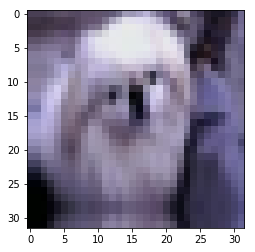

In [105]:
plt.imshow(data.trn_ds.denorm(x)[0]);

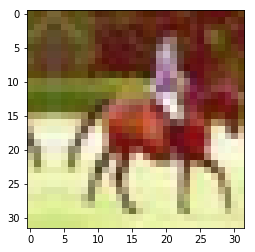

In [106]:
plt.imshow(data.trn_ds.denorm(x)[1]);

## Fully connected model


In [107]:
data = get_data(32,bs)

In [108]:
lr=1e-2

### Let's make a very simple model

This section will make `layers` number of fully connected linear layers 

```python
 self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
```

- ` x = x.view(x.size(0), -1)` - flatten the data as it comes in 
- `l_x = l(x)` - call the linear layer
- `x = F.relu(l_x)` - apply the relu to the layer
- `F.log_softmax(l_x, dim=-1)` so that we can make probabilites for 10 classes

In [109]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

#### Make a learner for our general model

In [110]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40,10]), data)

#### So what is our design?

- `3072` features = `32 x32 x 3 channels`
- `40` features going out and going in
- `10` because we have 10 classes we are trying to classify
- `122800` parameters

In [111]:
learn, [o.numel() for o in learn.model.parameters()]

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=3072, out_features=40)
     (1): Linear(in_features=40, out_features=10)
   )
 ), [122880, 40, 400, 10])

In [112]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 122920)])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', 410)]))])

In [113]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 74%|███████▍  | 118/160 [00:12<00:04,  9.67it/s, loss=11.1]

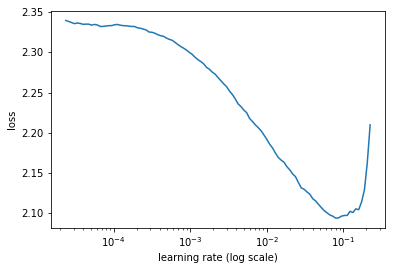

In [114]:
learn.sched.plot()

## Let's work our way to resnet: first Conv model: (0.56 acc)

**fully connected layer** - is really doing a dot product. Previously `122800` is a weight for every pixel, which isnt that usef useful.

But we want to use convolutions:

<img src= 'https://snag.gy/pjE1wH.jpg' />

So lets replace all the linear layers with `nn.Conv2d`. We want each progressive layer to be smaller. This can be done with `maxpooling`. These days we use a stride 2 convolution. It can be seen in this code block:

```python
    self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
```

<img src='https://adeshpande3.github.io/assets/Stride2.png' />

In [115]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [116]:
learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)

#### Note the change of the sizes

`32 -> 15 -> 7 -> 3 -> 1`

`AdaptiveMaxPool2d` - you don't tell it how bit of a pool that you need, but instead telling it the **output size** and the pool will calculate what size will be needed. Normal practice is to make a 1x1 max pool as the last layer to ensure that we have the right size.

- `for l in self.layers: x = F.relu(l(x))`- does all the conv layers
- `x = self.pool(x)` - adaptive max pool
- `x = x.view(x.size(0), -1)` - gets rid of training axis 1,1

In [117]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', 28880)])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
              OrderedDict

In [120]:
learn.lr_find(end_lr=100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 75%|███████▌  | 120/160 [00:12<00:04,  9.59it/s, loss=9.71]

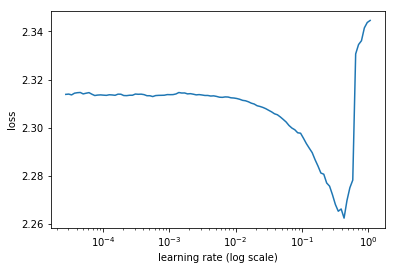

 75%|███████▌  | 120/160 [00:30<00:10,  4.00it/s, loss=9.71]

In [121]:
learn.sched.plot()

In [126]:
%time learn.fit(1e-1, 4, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

[ 0.       1.49958  1.41854  0.48878]                       
[ 1.       1.38663  1.31699  0.52909]                       
[ 2.       1.3289   1.26818  0.54769]                       
[ 3.       1.2829   1.23001  0.56185]                       

CPU times: user 1min 15s, sys: 1min 2s, total: 2min 18s
Wall time: 1min 16s


### Refactoring - grouping things to make life easier

We will make a custom conv. layer to bundle the `conv2d` along with a `relu`. We are also adding padding to take in account the corners of the image.

In [127]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x): return F.relu(self.conv(x))

In [128]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 10), data)

## Batch Norm (0.68 acc)

When we tried to add more layers we had problems training it. If i had smaller learning rates, it took forever. If we made larger learning rates, it would become unstable. The basic idea is that we have some vector of activations, that as we do matrix multiplication, that a matrix can easily get too large and grow too large. 

This additional code will normalize the matrix first by channel and later by filters.
```python
   if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
```
Turns out there's a conflict with SGD, and it won't help. So we make a new multiplier and new addition for each channel.
```
    self.a = nn.Parameter(torch.zeros(nf,1,1))
    self.m = nn.Parameter(torch.ones(nf,1,1))
```

Then we can do the multiplication. This seems weird because we are multiplying by 1 and adding zero. But this will let SGD shift the weights around in the `m` and `a` variables. We are normalizing the data, and SGD is moving and shifting it using far fewer variables than previously.

```
 return (x-self.means) / self.stds *self.m + self.a
```
This increases resiliency and lets us increase the learning rate and more learning rates


In [130]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        
        ### ================= NEW
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        ### ================= NEW
            
        return (x-self.means) / self.stds *self.m + self.a
    

Note: Every other framework will reset / edit these means / std which turns out is terrible for performance. `fast.ai` is the only library that currently leaves these values alone unless specified.
```python
self.means = x_chan.mean(1)[:,None,None]
self.stds  = x_chan.std (1)[:,None,None]
```

### Two changes

1. added teh `BnLayer`
2. Added a 'rich' `Conv2d` layer up front. Instead of a 3 x 3, we are doing a 5x5 / 7 x7 convolution with a large number of filters. 

In [131]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        
        ### added initial Conv2d Layer
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        
        ### added BN layer
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [132]:
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), data)

In [133]:
%time learn.fit(3e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.54923  1.37812  0.50578]                       
[ 1.       1.33422  1.2197   0.56551]                       

CPU times: user 41.4 s, sys: 33.8 s, total: 1min 15s
Wall time: 40.6 s


In [134]:
%time learn.fit(1e-1, 4, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

[ 0.       1.26706  1.12597  0.59944]                       
[ 1.       1.13483  1.03298  0.63434]                       
[ 2.       1.04099  0.97042  0.65475]                       
[ 3.       0.9706   0.9015   0.68176]                        

CPU times: user 1min 20s, sys: 1min 3s, total: 2min 24s
Wall time: 1min 18s


## Deep BatchNorm (0.64)

Let's make it an even deeper model. But we have to be mindful of the image size. If we keep reducing the image size, it will eventually be too small.

So each of our layers we make a `stride=1` layer which doesn't change teh size. Network is twice as deep, but have the same image size at the end.

```python
self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
```

```python
 for l,l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
```
Now the this is twice as deep, an should be able to help us out

In [139]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [143]:
learn = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)

In [144]:
%time learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.52921  1.34635  0.51389]                       
[ 1.       1.29377  1.17967  0.58279]                       

CPU times: user 44 s, sys: 33.7 s, total: 1min 17s
Wall time: 43.2 s


In [145]:
%time learn.fit(1e-2, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.11391  1.05577  0.62841]                       
[ 1.       1.04884  0.98173  0.65482]                       

CPU times: user 44 s, sys: 33.7 s, total: 1min 17s
Wall time: 43 s


Turns out that we are so deep that even batchnorm won't help us at all

## Resnet!

Resnet block: we are adding the original signal along with the convolution of the input

$$y = x + f(x) $$
$$ f(x) = y - x $$

Where `y` is the prediction of the next layer, and `x` is the prediction of the previous layer. The difference is actually the residual (`residual = y-x`). This is basically saying: find some weights to predict the error. We are continuously trying to predict the residual error, layer fater layer. 

This is similar to the idea of **boosting** from machine learning. 

In [148]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

Note that we have added 2 Resnet layers
and also note we have a function of a function of a function:

```
 x = l3(l2(l(x)))
```

In [149]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [150]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 10), data)

In [151]:
wd=1e-5

In [152]:
%time learn.fit(1e-2, 2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.62961  1.54065  0.44711]                       
[ 1.       1.38384  1.27545  0.54033]                       

CPU times: user 47.1 s, sys: 33.2 s, total: 1min 20s
Wall time: 46.5 s


In [153]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       1.18867  1.10428  0.60677]                       
[ 1.       1.14908  1.06663  0.61436]                       
[ 2.       1.02131  0.99241  0.64961]                       
[ 3.       1.07035  1.00853  0.64317]                       
[ 4.       0.94303  0.91505  0.67898]                        
[ 5.       0.85774  0.83062  0.70835]                        
[ 6.       0.80829  0.83869  0.70839]                        

CPU times: user 2min 46s, sys: 1min 56s, total: 4min 42s
Wall time: 2min 43s


In [ ]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

### Resnet2
Most of these resnet blocks have 2 convolutions. We call these skip connections
<img src= 'https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/resnets_1.png' />

In [155]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [156]:
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)

In [157]:
wd=1e-6

In [158]:
%time learn.fit(1e-2, 2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.69941  1.51531  0.46151]                       
[ 1.       1.45125  1.29084  0.54199]                       

CPU times: user 50.2 s, sys: 34.1 s, total: 1min 24s
Wall time: 49.7 s


In [163]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

In [ ]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

## Dogs vs. Cats

In [164]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [165]:
PATH = "data/dogscats/"
sz = 224
arch = resnet34
bs = 64

In [167]:
m = arch(True)

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

#### if we peak at teh resnet model
``` python
ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    
...
    
  )
  )
  (avgpool): AvgPool2d(kernel_size=7, stride=1, padding=0, ceil_mode=False, count_include_pad=True)
  (fc): Linear(in_features=512, out_features=1000)
)
```

We need to remove the last layer, and ideally be using the `AdapativeAveragePooling`, `AdaptiveMaxPooling` and concat them together. We goign to do a simple version, delete the last two layers and add a convolution which has 2 outputs. then average pooling, then softmax

`children(m)[:-2]` - leave out the last two layers


In [168]:
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [169]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

In [170]:
learn = ConvLearner.from_model_data(m, data)

#### just train the last layer

In [171]:
learn.freeze_to(-4) 

In [173]:
learn.fit(0.01, 1)

In [ ]:
learn.fit(0.01, 1, cycle_len=1)

## Class Activation Maps CAM

We going to use a technique CAM, and ask the model **'which parts of the picture are useful?'** ?

How does this work? It produces a matrix, simply equal to the value of `feature matrix` times `py` vector. `py` is the predictions. 

In [175]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = to_np(output)
    def remove(self): self.hook.remove()

In [174]:
x,y = next(iter(data.val_dl))
x,y = x[None,1], y[None,1]

vx = Variable(x.cuda(), requires_grad=True)

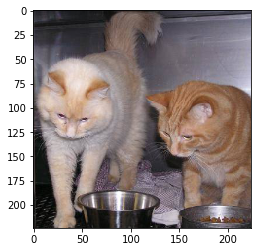

In [176]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

#### Reminder the predictions are [cat , dog]

```python
nn.Conv2d(512, 2, 3, padding=1), 
nn.AdaptiveAvgPool2d(1), Flatten(), 
```

The last layer averaged out the 'cattiness' of the pixels', so if we go up a layer above. 

`Forward Hook` - everytime it calculates a layer, it calls this hook. And in this case, made the hook save the features and then look at them later.

In [177]:
sf = SaveFeatures(m[-4])
py = m(Variable(x.cuda()))
sf.remove()

py = np.exp(to_np(py)[0]); py

array([ 1.,  0.], dtype=float32)

In [178]:
feat = np.maximum(0, sf.features[0])
feat.shape

(2, 7, 7)

In [179]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

array([[ 0.12739,  0.16946,  0.14072,  0.13504,  0.17374,  0.18246,  0.07364],
       [ 0.27871,  0.32266,  0.26193,  0.20904,  0.24067,  0.24784,  0.11502],
       [ 0.53374,  0.6641 ,  0.59405,  0.48618,  0.49895,  0.44552,  0.23511],
       [ 0.68743,  0.8717 ,  0.80648,  0.7566 ,  0.855  ,  0.79022,  0.454  ],
       [ 0.61305,  0.79002,  0.74769,  0.74808,  0.96233,  1.     ,  0.62686],
       [ 0.31683,  0.41362,  0.41097,  0.46197,  0.70958,  0.85436,  0.59416],
       [ 0.01643,  0.01299,  0.     ,  0.00983,  0.15675,  0.29076,  0.22025]], dtype=float32)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


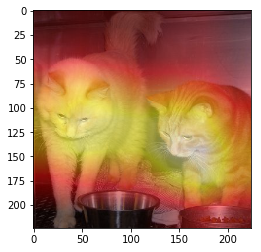

In [180]:
plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot');